# Tutorial on Bilevel Optimization
### with a stochastic auxiliary task example 

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from BilevelProblem.BilevelProblem import BilevelProblem
from utils import plot_1D_iterations, plot_2D_functions, plot_loss

torch.manual_seed(1)
random.seed(0)
np.random.seed(0)

We set the dimensions and generate the data, in this toy example we have linear data with Gaussian noise where values of the main task $y_{main} \in R^{m\times 1}$ are generated by the function $h^*(w)=X\theta+\epsilon$ parametrized by the true coefficient vector $\theta\in R^{n\times 1}$ with the feature matrix $X\in R^{m\times n}$. We also have values of a useful auxiliary task $y_{aux_1} \in R^{m\times 1}$ and values of a harmful auxiliary task $y_{aux_2} \in R^{m\times 1}$.

In [2]:
# Initialize dimesnions
n, m, m_out, m_in, batch = 2, 10000, 3000, 7000, 64
# The coefficient tensor of size (n,1) filled with values uniformally sampled from the range (0,1)
coef = np.array([[1],[1]]).astype('float32')#np.random.uniform(size=(n,1)).astype('float32')
coef_harm = np.array([[2],[-4]]).astype('float32')#np.random.uniform(size=(n,1)).astype('float32')
# The data tensor of size (m,n) filled with values uniformally sampled from the range (0,1)
X = np.random.uniform(size=(m, n)).astype('float32')
# True h_star
h_true = lambda X: X @ coef
h_harm = lambda X: X @ coef_harm
y_main = h_true(X)+np.random.normal(scale=1.2, size=(m,1)).astype('float32')
y_aux1 = h_true(X)+np.random.normal(size=(m,1)).astype('float32')
y_aux2 = h_harm(X)+np.random.normal(size=(m,1)).astype('float32')
y = np.hstack((y_main, y_aux1, y_aux2))
# Split X into 2 tensors with sizes [m_in, m_out] along dimension 0
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)
# Convert everything to PyTorch tensors
X_train, X_val, y_train, y_val, coef = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(coef)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("True coeficients:", coef)
print("X training data:", X_train[1:5])
print("y training labels:", y_train[1:5])
print()

dataset = [X_val,y_val,X_train,y_train]
maxiter = 2
step = 0.1
mu_0_value = 1.
mu0 = torch.full((2,1), mu_0_value)

X shape: (10000, 2)
y shape: (10000, 3)
True coeficients: tensor([[1.],
        [1.]])
X training data: tensor([[0.8118, 0.6260],
        [0.5623, 0.1411],
        [0.1003, 0.8191],
        [0.2995, 0.4990]])
y training labels: tensor([[ 1.2861,  2.3941,  2.2164],
        [ 0.0484,  3.0102,  0.4869],
        [ 1.3947,  1.4097, -1.1545],
        [ 0.6235,  0.0453, -1.1136]])



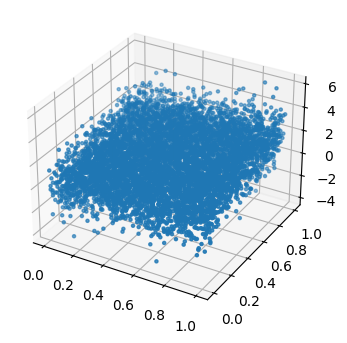

In [3]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train[:,0], marker='.')
plt.show()

## Implicit Differentiation

Here we consider a linear toy example of a bilevel problem where $X_v$ is a $m_v\times n$ **validtaion set** feature matrix (every row is a feature vector of dimension $n$) and $y_v$ is an $m_v$ dimensional **validation set** true value vector (every member is the true value for a corresponding feature vector). Similarly, $X_t \in R^{m_t\times n}$ and $y \in R^{m_t}$ constitute the **training set**. We have the outer objective:
$$
  F(\mu, \theta^*) = \lVert X_v\theta^* - y_v \lVert^2
$$
and the inner objective:
$$
  \theta^*(x)\in \arg \min_{\theta} G(\mu, \theta) = \lVert X_t\theta - y_{main} \lVert^2 + \mu_1 \lVert X_t\theta - y_{aux_1} \lVert^2 + \mu_2 \lVert X_t\theta - y_{aux_2} \lVert^2
$$
To use classical implicit differentiation we give a closed form solution of the lower objective $G(\mu, \theta)$ for a fixed $\mu$:

In [4]:
# A function to find optimal or closed form solution of h*
def find_theta_star(X, y, mu):
    """
    Find a closed form solution of theta for a fixed mu.
    """
    term1 = X.T @ X + mu[0]*X.T @ X + mu[1]*X.T @ X
    term2 = X.T @ y[:,0] + mu[0]*X.T @ y[:,1] + mu[1]*X.T @ y[:,2]
    return torch.linalg.solve(term1, term2)

We then provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the parameter vector $\theta$ and the outer parameter $\mu$:

In [5]:
# Objective functions
MSE = lambda th, X, y: (1/2)*torch.mean(torch.pow(((X @ th) - y),2))
fo = lambda mu, theta, X_out, y_out: MSE(theta,X_out,y_out[:,0])
fi = lambda mu, theta, X_in, y_in: MSE(theta,X_in,y_in[:,0]) + mu[0]*MSE(theta,X_in,y_in[:,1]) + mu[1]*MSE(theta,X_in,y_in[:,2])

# Gradients
og1 = lambda mu, theta, X_out, y_out: torch.full((n,1), 0.)
og2 = lambda mu, theta, X_out, y_out: torch.reshape(X_out.T @ (X_out @ theta - y_out[:,0]), (n,1))
ig22 = lambda mu, theta, X_in, y_in: X_in.T @ X_in + mu[0]*X_in.T @ X_in + mu[1]*X_in.T @ X_in
ig12 = lambda mu, theta, X_in, y_in: torch.stack((X_in.T @ (X_in @ theta - y_in[:,1]), X_in.T @ (X_in @ theta - y_in[:,2]))).T

Then we use **classical implicit differentiation** to find the optimal $\mu^*$:

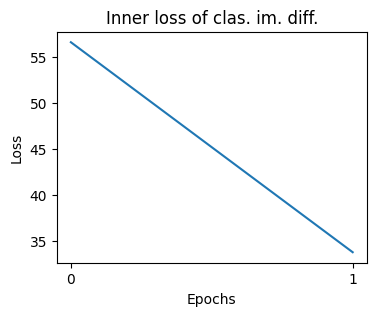

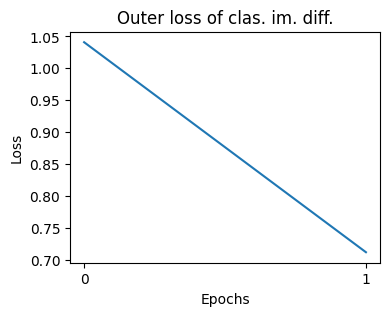

CLASSICAL IMPLICIT DIFFERENTIATION
Argmin of the outer objective: tensor([[66.2990],
        [ 0.0000]])
Average iteration time: 0.003792881965637207
Number of iterations: 2
True coefficients theta: tensor([[1.],
        [1.]])
Fitted coefficients theta: tensor([1.0019, 0.9908])


In [6]:
# Optimize using classical implicit differention
bp_classic = BilevelProblem(outer_objective=fo, inner_objective=fi, method="implicit_diff", data=dataset, gradients=[og1,og2,ig22,ig12], find_theta_star=find_theta_star)
mu_opt_c, iters_c, n_iters, times, inner_loss, outer_loss, theta = bp_classic.optimize(mu0, maxiter=maxiter, step=step)
plot_loss(inner_loss, title="Inner loss of clas. im. diff.")
plot_loss(outer_loss, title="Outer loss of clas. im. diff.")

# Show results
print("CLASSICAL IMPLICIT DIFFERENTIATION")
print("Argmin of the outer objective:", mu_opt_c)
print("Average iteration time:", np.average(times))
print("Number of iterations:", n_iters)
print("True coefficients theta:", coef)
print("Fitted coefficients theta:", theta)

## Neural Implicit Differentiation

To use neural implicit differentiation we reformulate the problem into a **functional bilevel problem**:
$$
  F(\mu, h^*) = \lVert h^*(X_v) - y_v \lVert^2
$$
and the inner objective:
$$
  h^*\in \arg \min_{h\in H} G(\mu, h) = \lVert h(X_t) - y_{main} \lVert^2 + \mu_1 \lVert h(X_t) - y_{aux_1} \lVert^2 + \mu_2 \lVert h(X_t) - y_{aux_2} \lVert^2
$$

We provide all necessary gradients to compute the gradient $\nabla_\mu F$ as functions of the function $h$ and the outer parameter $\mu$:

In [7]:
# Objective functions
MSE = lambda h, X, y: (1/2)*torch.mean(torch.pow((h(X) - y),2))
fo = lambda mu, h, X_out, y_out: MSE(h,X_out,y_out[:,0])
fi = lambda mu, h, X_in, y_in: MSE(h,X_in,y_in[:,0]) + mu[0]*MSE(h,X_in,y_in[:,1]) + mu[1]*MSE(h,X_in,y_in[:,2])

# Gradients
og1 = lambda mu, h, X_out, y_out: torch.full((n,1), 0.)
og2 = lambda mu, h, X_out, y_out: (h(X_out) - torch.reshape(y_out[:,0], (len(y_out),1)))
ig22 = lambda mu, h, X_in, y_in: torch.eye(len(y_in)) + mu[0]*torch.eye(len(y_in)) + mu[1]*torch.eye(len(y_in))
ig12 = lambda mu, h, X_in, y_in: torch.cat(((h(X_in) - torch.reshape(y_in[:,1], (len(y_in),1))), (h(X_in) - torch.reshape(y_in[:,2], (len(y_in),1)))),1)

Then we use **neural implicit differentiation** to find the optimal $\mu^*$:

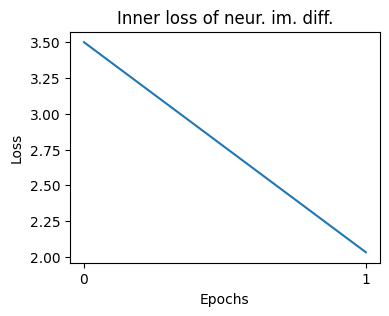

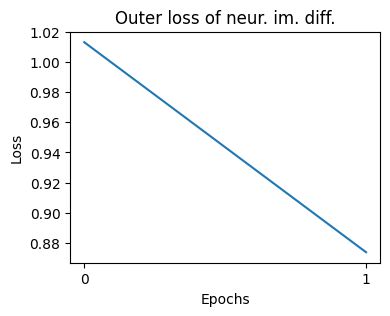

NEURAL IMPLICIT DIFFERENTIATION
Argmin of the outer objective: tensor([[1.7775],
        [0.0000]])
Average iteration time: 3.9917298555374146
Number of iterations: 2


In [8]:
# Optimize using neural implicit differention
bp_neural = BilevelProblem(outer_objective=fo, inner_objective=fi, method="neural_implicit_diff", data=dataset, gradients=[og1,og2,ig22,ig12])
mu_opt_n, iters_n, n_iters, times, inner_loss, outer_loss, h_star_n = bp_neural.optimize(mu0, maxiter=maxiter, step=step)
plot_loss(inner_loss, title="Inner loss of neur. im. diff.")
plot_loss(outer_loss, title="Outer loss of neur. im. diff.")

# Show results
print("NEURAL IMPLICIT DIFFERENTIATION")
print("Argmin of the outer objective:", mu_opt_n)
print("Average iteration time:", np.average(times))
print("Number of iterations:", n_iters)

## Camparison

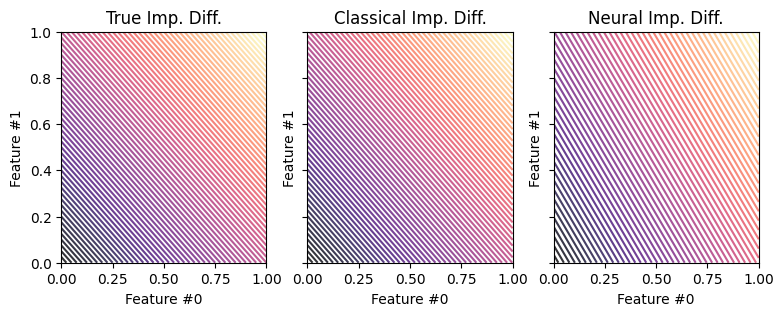

In [9]:
h_true = lambda X : X @ coef
h_theta = lambda theta : lambda X : X @ theta
h_star_c = bp_classic.h_star(h_theta)

f_c = lambda mu : torch.pow(torch.norm((h_star_c(X_train) - y_train)),2) + (mu.clone().detach())*torch.pow(torch.norm(h_star_c(X_train)),2)
f_n = lambda mu : torch.pow(torch.norm((h_star_n(X_val) - y_val)),2) + mu*torch.pow(torch.norm(h_star_n(X_val)),2)
plot_2D_functions(h_true, h_star_c, h_star_n, points=None, plot_x_lim=[0,mu_0_value], plot_y_lim=[0,1], plot_nb_contours=80, titles=["True Imp. Diff.","Classical Imp. Diff.","Neural Imp. Diff."])